In [1]:
import sys
#sys.path.insert(0, '/home/cameron/Projects/hypso-package/hypso/')

from hypso import Hypso1, Hypso2
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


from pyresample.geometry import SwathDefinition, AreaDefinition
from pyresample.bilinear.xarr import XArrayBilinearResampler 
from pyresample.future.resamplers.nearest import KDTreeNearestXarrayResampler



In [2]:
# Open the NetCDF file
#ds = xr.open_dataset("HYPSO2_HSI_frohavet_2025-05-22T11-20-44Z-l1d_L2_OCSMART.h5")
ds = xr.open_dataset("HYPSO2_HSI_aquawatchmoreton_2025-08-05T00-08-29Z-l1d_L2_OCSMART.h5")

# View dataset info
print(ds)

# Access a variable
#temperature = ds["temperature"]

# View data

<xarray.Dataset> Size: 25MB
Dimensions:           (phony_dim_0: 598, phony_dim_1: 1092)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables:
    L2_flags          (phony_dim_0, phony_dim_1) int16 1MB ...
    Latitude          (phony_dim_0, phony_dim_1) float32 3MB ...
    Longitude         (phony_dim_0, phony_dim_1) float32 3MB ...
    Relative_azimuth  (phony_dim_0, phony_dim_1) float32 3MB ...
    Sensor_zenith     (phony_dim_0, phony_dim_1) float32 3MB ...
    Solar_zenith      (phony_dim_0, phony_dim_1) float32 3MB ...
    chlor_a(oci)      (phony_dim_0, phony_dim_1) float64 5MB ...
    chlor_a(yoc)      (phony_dim_0, phony_dim_1) float64 5MB ...


In [3]:
print(np.nanmax(ds['chlor_a(oci)']))
print(np.nanmin(ds['chlor_a(oci)']))

19.241269870662737
0.001


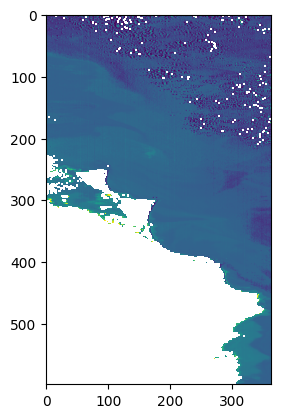

In [4]:
plt.imshow(ds['chlor_a(oci)'][:,::3], vmax=5)

In [5]:
chl = ds['chlor_a(yoc)']

In [6]:
import netCDF4 as nc
from pyresample.geometry import SwathDefinition

longitudes = ds['Longitude']
latitudes = ds['Latitude']




In [7]:
from pyproj import Proj
from pyresample import geometry
from pyresample.geometry import AreaDefinition
from pyresample.geometry import SwathDefinition



def generate_area_def(area_id: str,
                      proj_id: str,
                      description: str,
                      bbox: tuple[float, float, float, float],
                      height: int = None,
                      width: int = None
                      ) -> AreaDefinition:

    lon_0 = (bbox[2] - bbox[0])/2 + bbox[0]
    lat_ts = (bbox[3] - bbox[1])/2 + bbox[1]

    p = Proj(proj="stere", ellps="bessel", lat_0=90.0, lon_0=lon_0, lat_ts=lat_ts)

    projection = {"proj": "stere", 
                "ellps": "bessel", 
                "lat_0": 90.0, 
                "lon_0": lon_0, 
                "lat_ts": lat_ts, 
                "units": "m"}

    lower_left_x, lower_left_y = p(bbox[0], bbox[1])
    upper_right_x, upper_right_y = p(bbox[2], bbox[3])
    area_extent = (lower_left_x, lower_left_y, upper_right_x, upper_right_y)


    if (height is None) or (width is None):

        res = 300 #meters

        width = (area_extent[2] - area_extent[0]) / res
        height = (area_extent[3] - area_extent[1]) / res


    area_def = geometry.AreaDefinition(area_id, proj_id, description, projection,  width, height, area_extent)

    return area_def

In [8]:
bbox_max_lat = np.max(latitudes.to_numpy())
bbox_min_lat = np.min(latitudes.to_numpy())
bbox_max_lon = np.max(longitudes.to_numpy())
bbox_min_lon = np.min(longitudes.to_numpy())

bbox = [bbox_min_lon, bbox_min_lat, bbox_max_lon, bbox_max_lat]

In [9]:
area_def = generate_area_def('area', 'area', 'area', bbox)

KeyboardInterrupt: 

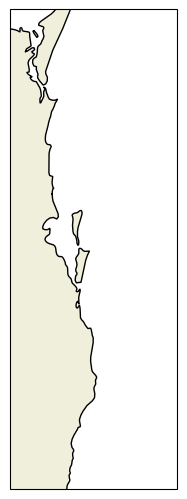

In [10]:
area_def

In [11]:
from hypso.resample import resample_dataarray_kd_tree_nearest

#target_swath = SwathDefinition(lons=longitudes, lats=latitudes)

#resampled = resample_dataarray_kd_tree_nearest(area_def=target_swath, 
#                                   data=chl,
#                                   latitudes=latitudes,
#                                   longitudes=longitudes
#                        )

swath_def = SwathDefinition(lons=longitudes, lats=latitudes)

kdtn = KDTreeNearestXarrayResampler(source_geo_def=swath_def, target_geo_def=area_def)

resampled_chl = kdtn.resample(data=chl[:,:], fill_value=np.nan, radius_of_influence=500)

/tmp/ipykernel_78906/3772861360.py:15: PerformanceWarning: KDTreeNearestXarrayResampler uses a dask-based implementation, but a pure numpy array was provided. Data will be converted to dask arrays for computation and then converted back. To avoid this warning convert your numpy array before providing it to the resampler.
  resampled_chl = kdtn.resample(data=chl[:,:], fill_value=np.nan, radius_of_influence=500)


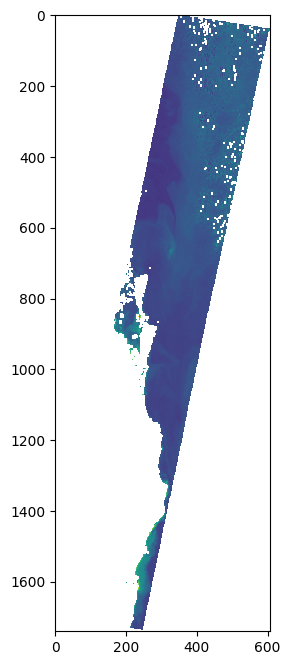

In [12]:
plt.figure(figsize=(12, 8))  
plt.imshow(resampled_chl, vmax=5)


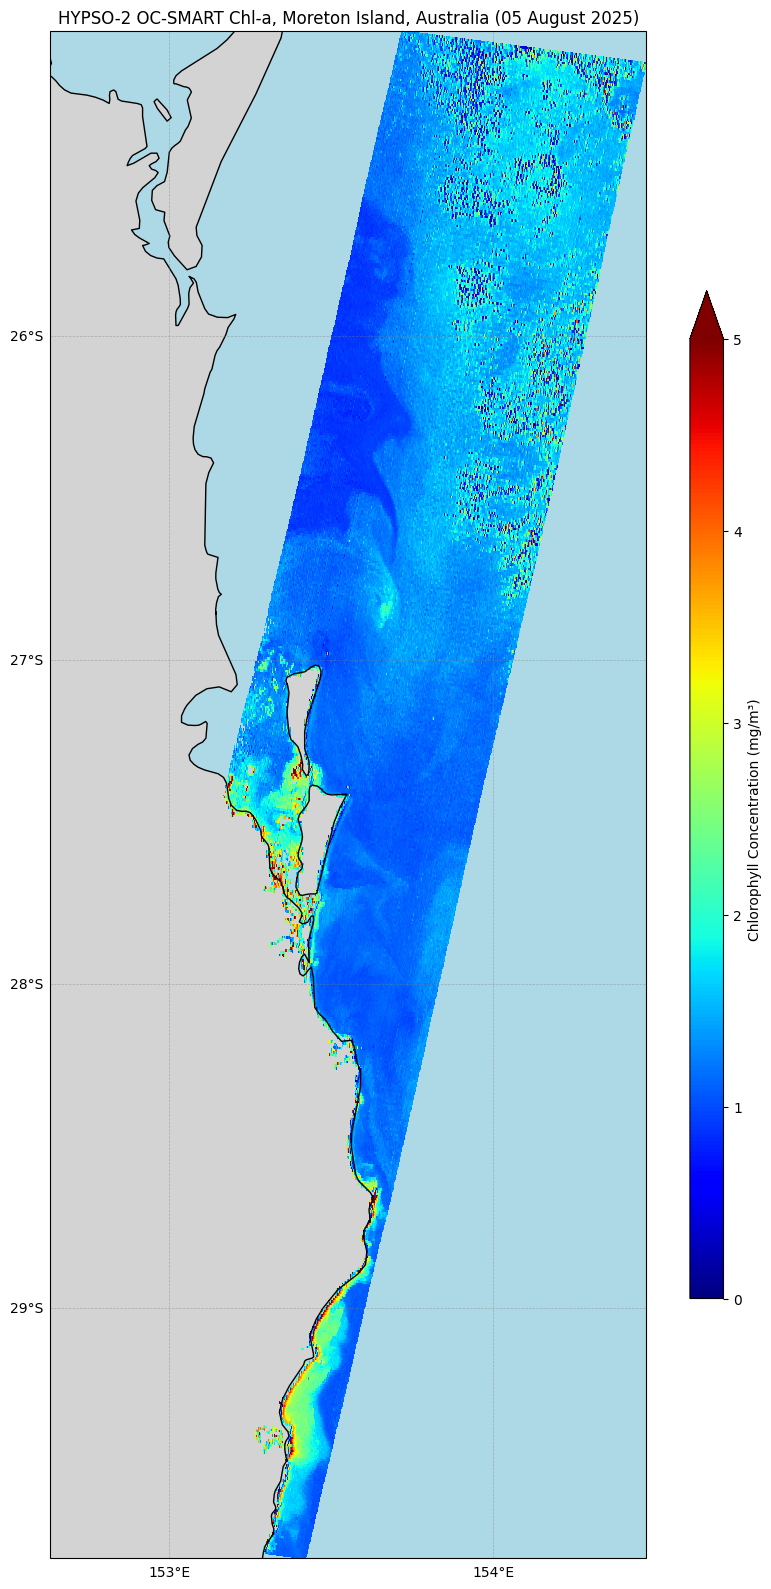

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.figure(figsize=(9, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([np.min(swath_def.lons), np.max(swath_def.lons), np.min(swath_def.lats), np.max(swath_def.lats)], crs=ccrs.PlateCarree())
# Plot the resampled data
mesh = ax.pcolormesh(swath_def.lons, swath_def.lats, chl, shading='auto', cmap='jet', transform=ccrs.PlateCarree(), vmin=0, vmax=5)

# Add basemap 
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')


# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


# Reduce longitude label density
import matplotlib.ticker as mticker
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 1))  # Change 10 to a larger value like 15 or 30 for fewer labels


# Add colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30)
cbar.set_label('Chlorophyll Concentration (mg/m³)')


plt.title("HYPSO-2 OC-SMART Chl-a, Moreton Island, Australia (05 August 2025)")

plt.tight_layout()

plt.savefig('chl.png')

In [14]:
import sys
#sys.path.insert(0, '/home/cameron/Projects/hypso-package')

from hypso import Hypso

l1a_nc_file = "/home/cameron/Nedlastinger/aquawatchmoreton_2025-08-05T00-08-29Z/aquawatchmoreton_2025-08-05T00-08-29Z-l1a.nc"

satobj = Hypso(path=l1a_nc_file, verbose=True)
#satobj.load_points_file(path=points_file, image_mode='standard', origin_mode='cube')
#satobj.run_indirect_georeferencing(points_file_path=points_file, flip=False)

#satobj.generate_l1b_cube()
#satobj.generate_l1c_cube()
#satobj.generate_l1d_cube()

[INFO] Loading L1a capture aquawatchmoreton_2025-08-05T00-08-29Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide


In [15]:
satobj.generate_l1b_cube()
satobj.generate_l1c_cube()
satobj.generate_l1d_cube()

[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running spectral correction...
[INFO] Running direct georeferencing...
[INFO] ADCS samples: 539
[INFO] ADCS time range: 1754351850.000000 to 1754352780.000000
[INFO] Frame time range: 1754352509.339966 to 1754352583.964966
[INFO] 298 sample(s) inside frame time range
[INFO] Interpolating 598 frames
[INFO] Computing pixel latitude and longitude coordinates ...
[INFO] Interpolating pixel coordinate gaps...
[INFO] Direct georeferencing done
[INFO] Running track geometry computations...
[INFO] Using UTM map: WGS 84 / UTM zone 56S EPSG: 32756
[INFO] Track geometry computations done.
[INFO] Running angles geometry computations...
[INFO] Computing local angles (sun and satellite azimuth and zenith angles) ...
[INFO] Using astropy on a subsampling of pixels ... (TODO skyfield may be faster)
[INFO] Interpolating the rest of the pixels ...
[INFO] Computing local angles done
[INFO] Angles geometry computations

In [26]:
longitudes

<xarray.DataArray 'Longitude' (phony_dim_0: 598, phony_dim_1: 1092)> Size: 3MB
array([[153.71748, 153.71817, 153.71884, ..., 154.47137, 154.47208, 154.4728 ],
       [153.71573, 153.71642, 153.71709, ..., 154.46968, 154.47038, 154.47108],
       [153.71388, 153.71457, 153.71524, ..., 154.46788, 154.46858, 154.46928],
       ...,
       [152.63678, 152.63748, 152.6382 , ..., 153.4243 , 153.42505, 153.42578],
       [152.63507, 152.63579, 152.63649, ..., 153.42268, 153.42342, 153.42415],
       [152.63344, 152.63414, 152.63486, ..., 153.42111, 153.42184, 153.42258]],
      dtype=float32)
Dimensions without coordinates: phony_dim_0, phony_dim_1

In [33]:
satobj_longitudes = xr.DataArray(
    satobj.longitudes,
    dims=["y", "x"],
)

satobj_latitudes = xr.DataArray(
    satobj.latitudes,
    dims=["y", "x"],
)



In [34]:
satobj_latitudes.shape

(598, 1092)

In [35]:
red

<xarray.DataArray (y: 598, x: 1092)> Size: 5MB
array([[0.02937818, 0.02921177, 0.03003752, ..., 0.04182679, 0.04268844,
        0.04374272],
       [0.02948959, 0.0293077 , 0.02930683, ..., 0.2401823 , 0.23713517,
        0.23704157],
       [0.02852856, 0.0282257 , 0.02830029, ..., 0.20275655, 0.19389893,
        0.19900777],
       ...,
       [0.05358881, 0.05052736, 0.0473263 , ..., 0.03350199, 0.03252603,
        0.03316042],
       [0.05123226, 0.05179191, 0.0513582 , ..., 0.03410004, 0.03389521,
        0.03331803],
       [0.04561989, 0.04710949, 0.04811317, ..., 0.03330963, 0.03309231,
        0.03393235]])
Coordinates:
  * y        (y) int64 5kB 0 1 2 3 4 5 6 7 8 ... 590 591 592 593 594 595 596 597
  * x        (x) int64 9kB 0 1 2 3 4 5 6 ... 1085 1086 1087 1088 1089 1090 1091
    band     int64 8B 72
Attributes:
    level:        L1d
    units:        sr^{-1}
    description:  Top-of-Atmosphere Reflectance (Rhot)
    correction:   None

In [46]:
from hypso.spectral_analysis import get_closest_wavelength_index
# Example: Replace these with your actual arrays
# Each array must be of shape (height, width)

red_wl = 630
green_wl = 550
blue_wl = 480

red_idx = get_closest_wavelength_index(satobj, red_wl)
green_idx = get_closest_wavelength_index(satobj, green_wl)
blue_idx = get_closest_wavelength_index(satobj, blue_wl)


red = satobj.l1d_cube[:,:,red_idx]
green = satobj.l1d_cube[:,:,green_idx]
blue = satobj.l1d_cube[:,:,blue_idx]

#swath_def = SwathDefinition(lons=satobj.longitudes.to_numpy(), lats=satobj.latitudes.to_numpy())
swath_def = SwathDefinition(lons=longitudes, lats=latitudes)

kdtn = KDTreeNearestXarrayResampler(source_geo_def=swath_def, target_geo_def=area_def)
resampled_red = kdtn.resample(data=red.to_numpy(), fill_value=np.nan, radius_of_influence=500)

kdtn = KDTreeNearestXarrayResampler(source_geo_def=swath_def, target_geo_def=area_def)
resampled_green = kdtn.resample(data=green[:,:].to_numpy(), fill_value=np.nan, radius_of_influence=500)

kdtn = KDTreeNearestXarrayResampler(source_geo_def=swath_def, target_geo_def=area_def)
resampled_blue = kdtn.resample(data=blue[:,:].to_numpy(), fill_value=np.nan, radius_of_influence=500)

/tmp/ipykernel_78906/1031364525.py:22: PerformanceWarning: KDTreeNearestXarrayResampler uses a dask-based implementation, but a pure numpy array was provided. Data will be converted to dask arrays for computation and then converted back. To avoid this warning convert your numpy array before providing it to the resampler.
  resampled_red = kdtn.resample(data=red.to_numpy(), fill_value=np.nan, radius_of_influence=500)
/tmp/ipykernel_78906/1031364525.py:25: PerformanceWarning: KDTreeNearestXarrayResampler uses a dask-based implementation, but a pure numpy array was provided. Data will be converted to dask arrays for computation and then converted back. To avoid this warning convert your numpy array before providing it to the resampler.
  resampled_green = kdtn.resample(data=green[:,:].to_numpy(), fill_value=np.nan, radius_of_influence=500)
/tmp/ipykernel_78906/1031364525.py:28: PerformanceWarning: KDTreeNearestXarrayResampler uses a dask-based implementation, but a pure numpy array was pr

In [47]:
x = 300
y = 150

print(satobj.l1d_cube[x,y,red_idx])
print(satobj.l1d_cube[x,y,green_idx])
print(satobj.l1d_cube[x,y,blue_idx])

<xarray.DataArray ()> Size: 8B
array(0.02777018)
Coordinates:
    y        int64 8B 300
    x        int64 8B 150
    band     int64 8B 72
Attributes:
    level:        L1d
    units:        sr^{-1}
    description:  Top-of-Atmosphere Reflectance (Rhot)
    correction:   None
<xarray.DataArray ()> Size: 8B
array(0.05760521)
Coordinates:
    y        int64 8B 300
    x        int64 8B 150
    band     int64 8B 49
Attributes:
    level:        L1d
    units:        sr^{-1}
    description:  Top-of-Atmosphere Reflectance (Rhot)
    correction:   None
<xarray.DataArray ()> Size: 8B
array(0.09178658)
Coordinates:
    y        int64 8B 300
    x        int64 8B 150
    band     int64 8B 29
Attributes:
    level:        L1d
    units:        sr^{-1}
    description:  Top-of-Atmosphere Reflectance (Rhot)
    correction:   None


(1740, 606, 3)


/tmp/ipykernel_78906/769580588.py:15: RuntimeWarning: invalid value encountered in cast
  rgb_image = rgb_image.astype(np.uint8)


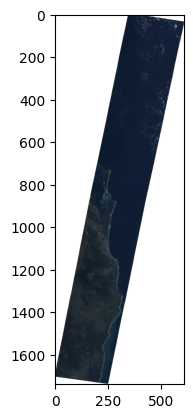

In [48]:
#red = resampled_l1d[0][:,:,red_idx].to_numpy()
#green = resampled_l1d[0][:,:,green_idx].to_numpy()
#blue = resampled_l1d[0][:,:,blue_idx].to_numpy()

# Stack the arrays along the last axis to form an RGB image
#rgb_image = np.stack((red, green, blue), axis=-1)

rgb_image = np.stack((resampled_red, resampled_green, resampled_blue), axis=-1)

print(rgb_image.shape)

max_value = np.nanmax(rgb_image)
rgb_image = rgb_image/max_value*255

rgb_image = rgb_image.astype(np.uint8)

# Create alpha channel: 0 where RGB is (0,0,0), else 255
alpha = np.where(np.all(rgb_image == [0, 0, 0], axis=-1), 0, 255).astype(np.uint8)

# Combine RGB and alpha into RGBA image
rgba_image = np.dstack((rgb_image, alpha))

plt.imshow(rgba_image)

(598, 1092, 3)


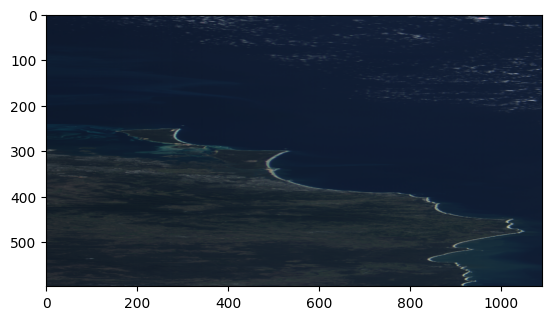

In [77]:

rgb_image = np.stack((red, green, blue), axis=-1)

print(rgb_image.shape)

max_value = np.nanmax(rgb_image)
rgb_image = rgb_image/max_value*255

rgb_image = rgb_image.astype(np.uint8)

# Create alpha channel: 0 where RGB is (0,0,0), else 255
alpha = np.where(np.all(rgb_image == [0, 0, 0], axis=-1), 0, 255).astype(np.uint8)

# Combine RGB and alpha into RGBA image
rgba_image = np.dstack((rgb_image, alpha))

plt.imshow(rgba_image)


M,N = red.shape
facecolors = rgba_image.reshape(-1, 4)
facecolors = [tuple(fc) for fc in facecolors]
#facecolors = np.array(facecolors).reshape(M, N, -1)

dummy_data = np.ones((M, N))

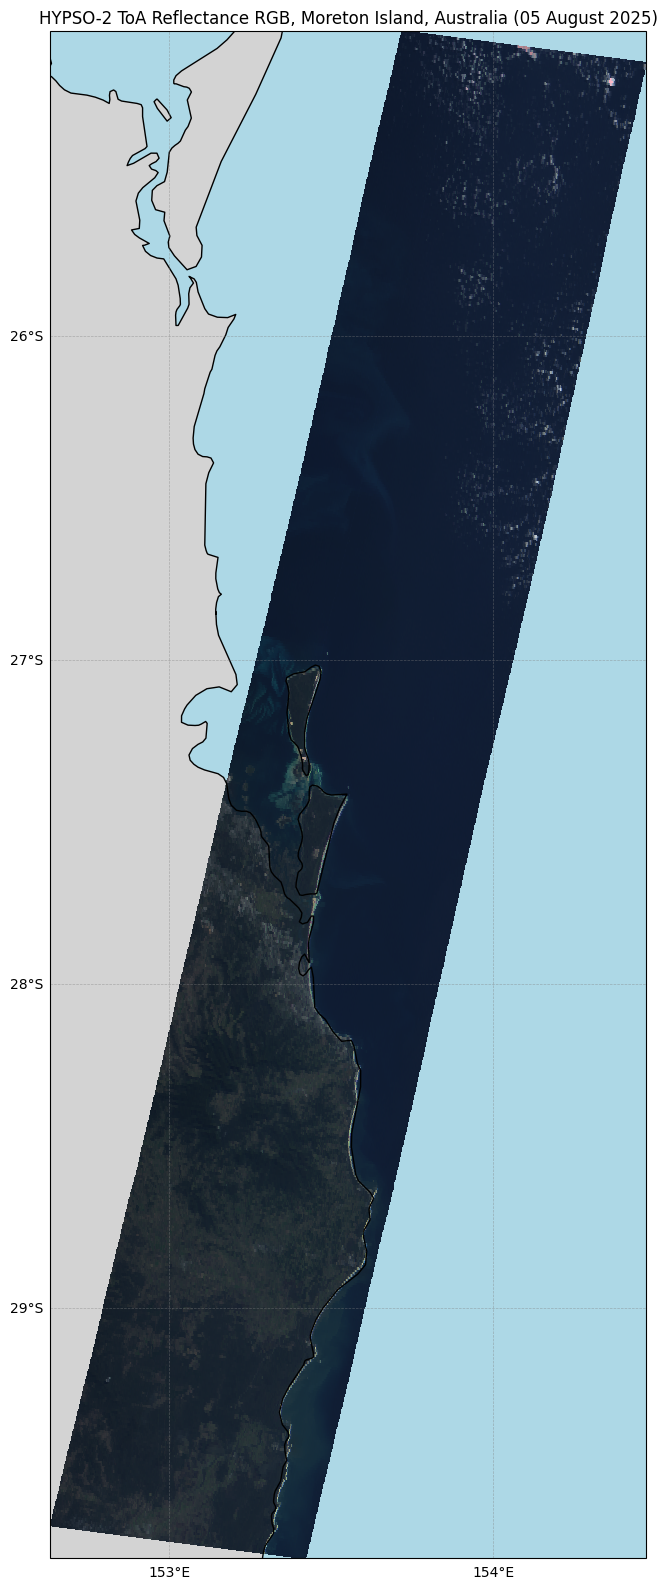

In [84]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.figure(figsize=(9, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([np.min(swath_def.lons), np.max(swath_def.lons), np.min(swath_def.lats), np.max(swath_def.lats)], crs=ccrs.PlateCarree())
# Plot the resampled data



#mesh = ax.pcolormesh(swath_def.lons, swath_def.lats, red[:,:], shading='auto', cmap='jet', transform=ccrs.PlateCarree(), vmin=0, vmax=5)
mesh = ax.pcolormesh(swath_def.lons, swath_def.lats, rgba_image[:,:,:], facecolors=facecolors, transform=ccrs.PlateCarree())
#mesh.set_array(None)


#extent = [np.min(swath_def.lons), np.max(swath_def.lons),
#          np.min(swath_def.lats), np.max(swath_def.lats)]


# Overlay RGBA image
#ax.imshow(rgba_image, origin='upper', extent=extent, transform=ccrs.PlateCarree())
#ax.imshow(rgba_image)

# Add basemap 
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')


# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


# Reduce longitude label density
import matplotlib.ticker as mticker
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 1))  # Change 10 to a larger value like 15 or 30 for fewer labels


# Add colorbar
#cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30)
#cbar.set_label('Chlorophyll Concentration (mg/m³)')


plt.title("HYPSO-2 ToA Reflectance RGB, Moreton Island, Australia (05 August 2025)")

plt.tight_layout()

plt.savefig('rgb.png')



(598, 1092, 3)


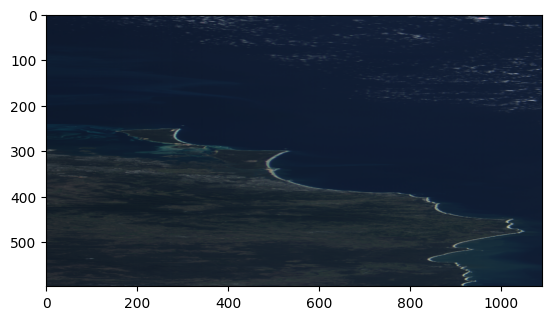

In [63]:
M*N

653016

In [61]:
len(facecolors)

653016

/tmp/ipykernel_71713/4261789380.py:1: PerformanceWarning: KDTreeNearestXarrayResampler uses a dask-based implementation, but a pure numpy array was provided. Data will be converted to dask arrays for computation and then converted back. To avoid this warning convert your numpy array before providing it to the resampler.
  resampled_red = kdtn.resample(data=red[:,:], fill_value=np.nan, radius_of_influence=500)


ValueError: Data dimensions do not match source area dimensions.

In [32]:
chl.shape

(598, 1092)

In [33]:
red.shape

(598, 1092)

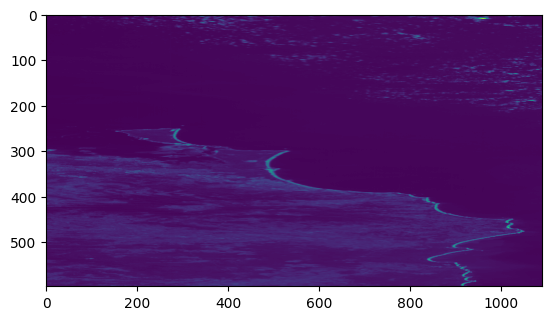

In [38]:
plt.imshow(red)

In [40]:
chl

<xarray.DataArray 'chlor_a(yoc)' (phony_dim_0: 598, phony_dim_1: 1092)> Size: 5MB
array([[1.442014, 1.43304 , 1.363641, ..., 1.624863, 1.923728, 2.188426],
       [1.226519, 1.350416, 1.280551, ..., 1.988194, 2.022751, 2.001336],
       [1.466751, 1.340064, 1.387347, ..., 1.825453, 1.4808  , 1.821515],
       ...,
       [     nan,      nan,      nan, ..., 1.101024, 1.087607, 1.04937 ],
       [     nan,      nan,      nan, ..., 1.118397, 1.081563, 1.105984],
       [     nan,      nan,      nan, ..., 1.089876, 1.084623, 1.117423]])
Dimensions without coordinates: phony_dim_0, phony_dim_1

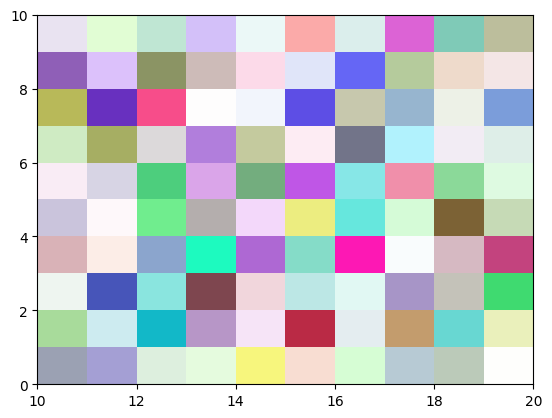

In [71]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(100)

x = np.arange(10, 21)
y = np.arange(0, 11)
x, y = np.meshgrid(x, y)

img = np.random.randint(low=0, high=255, size=(10, 10, 4))

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, img[:, :,0], facecolors=img.reshape(-1, 4)/255)
# This is necessary to let the `color` argument determine the color
mesh.set_array(None)
plt.show()

In [72]:
img.shape

(10, 10, 4)

In [75]:
(img.reshape(-1, 4)/255).shape

(100, 4)

In [76]:
facecolors.shape

(598, 1092, 4)